Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_eventcode     │ (None, 512)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_actor1        │ (None, 300)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_actor2        │ (None, 300)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_singular      │ (None, 6)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │     32,832 │ input_eventcode[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │     19,264 │ input_actor1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │     19,264 │ input_actor2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 32)        │        224 │ input_singular[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 224)       │          0 │ dense[0][0],      │
│ (Concatenate)       │                   │            │ dense_1[0][0],    │
│                     │                   │            │ dense_2[0][0],    │
│                     │                   │            │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │     28,800 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │        129 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 100,513 (392.63 KB)

 Trainable params: 100,513 (392.63 KB)

 Non-trainable params: 0 (0.00 B)

Processing dataset: 100%|██████████| 9/9 [00:00<00:00, 152.40it/s]


Epoch 1/1


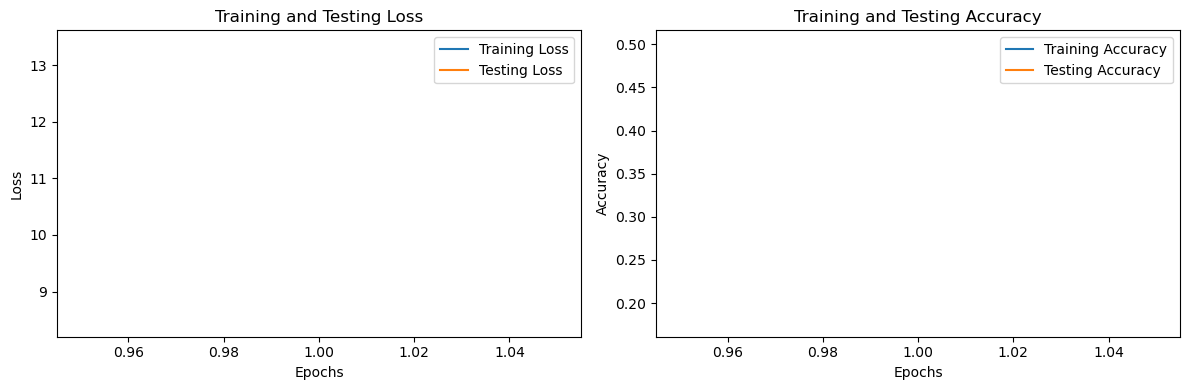

In [1]:
import joblib
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Define the inputs for the model
input_eventcode = Input(shape=(512,), name='input_eventcode')
input_actor1 = Input(shape=(300,), name='input_actor1')
input_actor2 = Input(shape=(300,), name='input_actor2')
input_singular = Input(shape=(6,), name='input_singular')  # Assuming there are 6 singular features

# Process the EventCode input
x_eventcode = Dense(64, activation='relu')(input_eventcode)

# Process the Actor1Name input
x_actor1 = Dense(64, activation='relu')(input_actor1)

# Process the Actor2Name input
x_actor2 = Dense(64, activation='relu')(input_actor2)

# Process the singular features input
x_singular = Dense(32, activation='relu')(input_singular)

# Concatenate the processed inputs
concatenated = Concatenate()([x_eventcode, x_actor1, x_actor2, x_singular])

# Fully connected layer
x = Dense(128, activation='relu')(concatenated)
x = Dropout(rate=0.5)(x)

# Output layer for binary classification
output = Dense(1, activation='sigmoid')(x)

# Define the model with four inputs and one output
model = Model(inputs=[input_eventcode, input_actor1, input_actor2, input_singular], outputs=output)

# Compile the model with a lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

# Load the compressed binary file
combined_data_2015 = joblib.load('combined_data_test.pkl.gz')

# Group inputs by labels
grouped_inputs = {}

for data in tqdm(combined_data_2015, desc="Processing dataset"):
    label = data['label']
    if label not in grouped_inputs:
        grouped_inputs[label] = {
            'eventcode': [],
            'actor1': [],
            'actor2': [],
            'singular': []
        }
    
    for entry in data['data']:
        # Extract the relevant features
        eventcode = entry['EventCode']
        actor1_name = entry['Actor1Name']
        actor2_name = entry['Actor2Name']
        singular_features = [
            entry['NumMentions'],
            entry['NumSources'],
            entry['Actor1Geo_Lat'],
            entry['Actor1Geo_Long'],
            entry['Actor2Geo_Lat'],
            entry['Actor2Geo_Long']
        ]

        # Append the features to the grouped lists
        grouped_inputs[label]['eventcode'].append(eventcode)
        grouped_inputs[label]['actor1'].append(actor1_name)
        grouped_inputs[label]['actor2'].append(actor2_name)
        grouped_inputs[label]['singular'].append(singular_features)

# Split the data into training and testing sets
train_data = {}
test_data = {}

for label, inputs in grouped_inputs.items():
    eventcode_train, eventcode_test = train_test_split(inputs['eventcode'], test_size=0.2, random_state=42)
    actor1_train, actor1_test = train_test_split(inputs['actor1'], test_size=0.2, random_state=42)
    actor2_train, actor2_test = train_test_split(inputs['actor2'], test_size=0.2, random_state=42)
    singular_train, singular_test = train_test_split(inputs['singular'], test_size=0.2, random_state=42)
    
    train_data[label] = {
        'eventcode': tf.convert_to_tensor(eventcode_train),
        'actor1': tf.convert_to_tensor(actor1_train),
        'actor2': tf.convert_to_tensor(actor2_train),
        'singular': tf.convert_to_tensor(singular_train),
        'labels': tf.convert_to_tensor([label] * len(eventcode_train))
    }
    
    test_data[label] = {
        'eventcode': tf.convert_to_tensor(eventcode_test),
        'actor1': tf.convert_to_tensor(actor1_test),
        'actor2': tf.convert_to_tensor(actor2_test),
        'singular': tf.convert_to_tensor(singular_test),
        'labels': tf.convert_to_tensor([label] * len(eventcode_test))
    }

# Define the custom training loop
def custom_training_loop(model, train_data, test_data, epochs=200):
    train_loss = []
    train_acc = []
    test_loss = []
    test_acc = []

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        
        epoch_train_loss = []
        epoch_train_acc = []
        epoch_test_loss = []
        epoch_test_acc = []
        
        # Training phase
        for label, inputs in train_data.items():
            # Train the model on the aggregated data
            history = model.train_on_batch([inputs['eventcode'], inputs['actor1'], inputs['actor2'], inputs['singular']], inputs['labels'])
            epoch_train_loss.append(history[0])
            epoch_train_acc.append(history[1])
        
        # Testing phase
        for label, inputs in test_data.items():
            # Evaluate the model on the aggregated data
            history = model.evaluate([inputs['eventcode'], inputs['actor1'], inputs['actor2'], inputs['singular']], inputs['labels'], verbose=0)
            epoch_test_loss.append(history[0])
            epoch_test_acc.append(history[1])
        
        # Aggregate the losses and accuracies for the epoch
        train_loss.append(sum(epoch_train_loss) / len(epoch_train_loss))
        train_acc.append(sum(epoch_train_acc) / len(epoch_train_acc))
        test_loss.append(sum(epoch_test_loss) / len(epoch_test_loss))
        test_acc.append(sum(epoch_test_acc) / len(epoch_test_acc))

    return train_loss, train_acc, test_loss, test_acc

# Train the model using the custom training loop
train_loss, train_acc, test_loss, test_acc = custom_training_loop(model, train_data, test_data, epochs = 2)

# Plot the training and testing accuracy and loss
epochs = range(1, 3)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, test_loss, label='Testing Loss')
plt.title('Training and Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, test_acc, label='Testing Accuracy')
plt.title('Training and Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()